In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p /content/oilspill_dataset


In [ ]:
!wget -q https://zenodo.org/records/10555314/files/dataset.zip -O /content/oilspill_dataset/dataset.zip


In [ ]:
!unzip -q /content/oilspill_dataset/dataset.zip -d /content/oilspill_dataset/


In [ ]:
print("✅ Dataset ready in /content/oilspill_dataset/")


✅ Dataset ready in /content/oilspill_dataset/


In [ ]:
!ls -R /content/oilspill_dataset | head -n 50


/content/oilspill_dataset:
dataset.zip
label_colors.txt
test
train
val

/content/oilspill_dataset/test:
images
masks

/content/oilspill_dataset/test/images:
Oil (1007).jpg
Oil (1019).jpg
Oil (1024).jpg
Oil (1026).jpg
Oil (1037).jpg
Oil (1038).jpg
Oil (1042).jpg
Oil (1044).jpg
Oil (1047).jpg
Oil (1049).jpg
Oil (1050).jpg
Oil (1055).jpg
Oil (1057).jpg
Oil (1061).jpg
Oil (1067).jpg
Oil (1069).jpg
Oil (1071).jpg
Oil (1076).jpg
Oil (1085).jpg
Oil (1095).jpg
Oil (1097).jpg
Oil (109).jpg
Oil (1109).jpg
Oil (110).jpg
Oil (1113).jpg
Oil (1124).jpg
Oil (112).jpg
Oil (1130).jpg
Oil (1138).jpg
Oil (1140).jpg
Oil (1145).jpg
Oil (1151).jpg
Oil (1155).jpg
Oil (115).jpg
Oil (1164).jpg
Oil (1171).jpg
Oil (1175).jpg
Oil (1177).jpg


In [ ]:
import os

base_path = "/content/oilspill_dataset"
for split in ["train", "val", "test"]:
    images = os.path.join(base_path, split, "images")
    masks  = os.path.join(base_path, split, "masks")   # ✅ correct folder
    print(f"{split.upper()} → {len(os.listdir(images))} images | {len(os.listdir(masks))} masks")


TRAIN → 811 images | 811 masks
VAL → 203 images | 203 masks
TEST → 254 images | 254 masks


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_path = "/content/oilspill_dataset"
img_size = (256, 256)   # target size


In [ ]:
import os, cv2

train_mask_dir = "/content/oilspill_dataset/train/masks"
sample_mask = os.listdir(train_mask_dir)[0]
print("Example mask file:", sample_mask)

mask_path = os.path.join(train_mask_dir, sample_mask)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print("Mask shape:", None if mask is None else mask.shape, "dtype:", None if mask is None else mask.dtype)


Example mask file: Oil (988).png
Mask shape: (1080, 1920) dtype: uint8


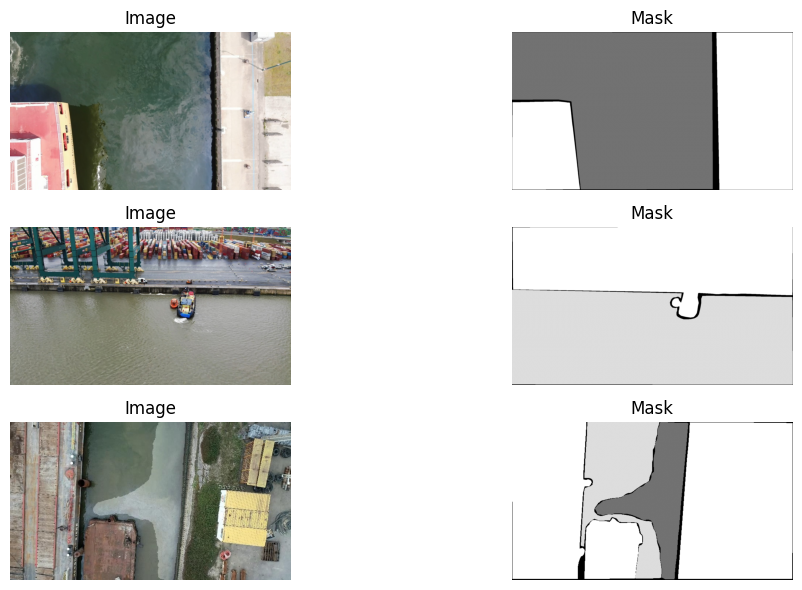

In [ ]:
import random
import matplotlib.pyplot as plt

train_img_dir  = "/content/oilspill_dataset/train/images"
train_mask_dir = "/content/oilspill_dataset/train/masks"

# Pick random files but ensure they exist in both folders
img_files  = sorted(os.listdir(train_img_dir))
mask_files = sorted(os.listdir(train_mask_dir))
sample_ids = random.sample(range(len(img_files)), 3)

plt.figure(figsize=(12,6))
for i, idx in enumerate(sample_ids):
    img_name  = img_files[idx]
    mask_name = mask_files[idx]   # using the same index

    img  = cv2.imread(os.path.join(train_img_dir, img_name))
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(os.path.join(train_mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

    plt.subplot(3,2,2*i+1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(3,2,2*i+2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import cv2

img_size = (256, 256)

def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0  # normalize to [0,1]
    return img

def preprocess_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    mask = mask / 255.0  # convert to [0,1]
    mask = np.expand_dims(mask, axis=-1)  # add channel dimension
    return mask


In [ ]:
# example batch from training set
img_paths  = [os.path.join(train_img_dir, f) for f in img_files[:5]]
mask_paths = [os.path.join(train_mask_dir, f) for f in mask_files[:5]]

X = np.array([preprocess_image(p) for p in img_paths])
Y = np.array([preprocess_mask(p) for p in mask_paths])

print("Images shape:", X.shape, "Masks shape:", Y.shape)


Images shape: (5, 256, 256, 3) Masks shape: (5, 256, 256, 1)


In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

base_path = "/content/oilspill_dataset"
img_size  = (256,256)

def load_dataset(split):
    img_dir  = os.path.join(base_path, split, "images")
    mask_dir = os.path.join(base_path, split, "masks")
    img_files  = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    X = []
    Y = []
    for i in range(len(img_files)):
        img_path  = os.path.join(img_dir, img_files[i])
        mask_path = os.path.join(mask_dir, mask_files[i])

        img  = cv2.imread(img_path)
        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img  = cv2.resize(img, img_size) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        X.append(img)
        Y.append(mask)

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

X_train, Y_train = load_dataset("train")
X_val,   Y_val   = load_dataset("val")

print("Train:", X_train.shape, Y_train.shape)
print("Val  :", X_val.shape,   Y_val.shape)


Train: (811, 256, 256, 3) (811, 256, 256, 1)
Val  : (203, 256, 256, 3) (203, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_size=(256,256,3)):
    inputs = layers.Input(input_size)

    # --- Encoder ---
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # --- Bottleneck ---
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    # --- Decoder ---
    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)

    return Model(inputs=[inputs], outputs=[outputs])

model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Dice coefficient metric
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) +
                                          tf.keras.backend.sum(y_pred_f) + smooth)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coef]
)


In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=20
)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 123s 821ms/step - accuracy: 0.0072 - dice_coef: 0.5854 - loss: 0.6714 - val_accuracy: 0.0229 - val_dice_coef: 0.6007 - val_loss: 0.6333
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 386ms/step - accuracy: 0.0201 - dice_coef: 0.6105 - loss: 0.6396 - val_accuracy: 0.0174 - val_dice_coef: 0.6259 - val_loss: 0.6426
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - accuracy: 0.0231 - dice_coef: 0.6166 - loss: 0.6324 - val_accuracy: 0.0247 - val_dice_coef: 0.6151 - val_loss: 0.6233
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - accuracy: 0.0277 - dice_coef: 0.6245 - loss: 0.6245 - val_accuracy: 0.0286 - val_dice_coef: 0.5973 - val_loss: 0.6261
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - accuracy: 0.0316 - dice_coef: 0.6263 - loss: 0.6193 - val_accuracy: 0.0263 - val_dice_coef: 0.6084 - val_loss: 0.6221
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 386ms/step - accuracy: 0.0276 - dice_coef: 0.6342 - loss: 0.6170 - val_accuracy:

In [ ]:
model.save("/content/oilspill_unet.h5")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**data_gen_args)


In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) +
                                               tf.keras.backend.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
!ls /content/


sample_data
